In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt
# from IPython.display import display

In [2]:
#### Kaggle Website Data Description: (https://www.kaggle.com/wendykan/lending-club-loan-data)

# Update on 2019-03-18 — "Updating files until end of 2018"

# Resulting Assumption — This 2007-2018 data represents "present" data as of 11:59 PM on December 31, 2018.
#                        Therefore, any loans originating after Dec. 2015 have less than
#                        36 months of data and should be excluded in Pt. 2 & Pt. 3.


# Original Description:

# These files contain complete loan data for all loans issued through the 2007-2015,
# including the current loan status (Current, Late, Fully Paid, etc.) and latest
# payment information. The file containing loan data through the "present" contains
# complete loan data for all loans issued through the previous completed calendar quarter.

In [3]:
# Note: Comments = Data dictionary field descriptions from './LCDataDictionary.xlsx' > LoanStats

rel_fields = [
              'loan_amnt',     # — The listed amount of the loan applied for by the borrower.
                               #   If at some point in time, the credit department reduces the
                               #   loan amount, then it will be reflected in this value.

              'funded_amnt',   # — The total amount committed to that loan at that point in
                               #   time.

              'term',          # — The number of payments on the loan. Values are in months
                               #   and can be either 36 or 60.

              'int_rate',      # — Interest Rate on the loan
    
              'grade',         # — LC [Lending Club] assigned loan grade
    
              'annual_inc',    # — The self-reported annual income provided by the borrower
                               #   during registration.

              'issue_d',       # — The month which the loan was funded
    
              'dti',           # — A ratio calculated using the borrower’s total monthly debt
                               #   payments on the total debt obligations, excluding mortgage
                               #   and the requested LC loan, divided by the borrower’s
                               #   self-reported monthly income.
    
              'revol_bal',     # — Total credit revolving balance

              'total_pymnt',   # — Payments received to date for total amount funded

              'loan_status'    # — Current status of the loan
    
             ]


In [4]:
#### Load loan data:
raw_input = pd.read_csv('./loan.csv', usecols=rel_fields)
cln_input = raw_input.copy()

In [5]:
# #### Convert term into an integer:
# cln_input['term'] = cln_input['term'].str.strip().str.replace(' months','').astype(int)

In [6]:
#### Create grade_num for logistic regression (might use one_hot instead)
grade_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6}
cln_input['grade_num'] = cln_input['grade'].map(grade_dict)

In [7]:
#### Break issue date into months & years
cln_input[['issue_d_month_raw','issue_d_year']] = cln_input['issue_d'].str.split('-',expand=True).astype(str)



#### Add month numbers to month strings for easy sorting
month_list = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
month_dict = {}
for im,month in enumerate(month_list):
    im_str = str(im+1) if len(str(im+1)) >= 2 else '0'+str(im+1)
    month_dict[month] = im_str+'-'+month
cln_input['issue_d_month'] = cln_input['issue_d_month_raw'].map(month_dict)
cln_input['issue_d_month_num'] = cln_input['issue_d_month'].str.slice(stop=2)

#### Create numerical YYYYMM date for easy chronological sorting
cln_input['issue_d_num'] = (cln_input['issue_d_year'].astype(str)+cln_input['issue_d_month_num']).astype(int)

#### Create numerical month column for regression (might use one_hot instead)
cln_input['issue_d_month_num'] = cln_input['issue_d_month_num'].astype(int)

cln_input = cln_input.drop('issue_d_month_raw',axis=1).sort_values('issue_d_num',ascending=True).reset_index(drop=True)

In [8]:
#### Convert "Does not meet the credit policy. Status:___" loan_status flags to the text after "Status:".
cln_input['credit_pol_flg'] = 1.0
cln_input.loc[cln_input['loan_status'].str.contains('Does not meet the credit policy'),'credit_pol_flg'] = 0.0
cln_input['loan_status'] = cln_input['loan_status'].str.split(':').apply(lambda x: x[-1])

#### Create "loan status revised" column — combining ["In Grace Period", "Late 16-30", & "Late 31-120"] into "Late"
cln_input['loan_status_rev'] = cln_input['loan_status']


#### Grouping "Late" loan_status flags together and creating a lateness flag
cln_input['lateness'] = 0.0
cln_input.loc[cln_input['loan_status'].str.contains('Fully Paid'),'lateness'] = -1.0
cln_input.loc[cln_input['loan_status'].str.contains('In Grace Period'),'lateness'] = 1.0
cln_input.loc[cln_input['loan_status'].str.contains('Late'),'lateness'] = 2.0
cln_input.loc[(cln_input['loan_status'].str.contains('Late'))&(cln_input['loan_status'].str.contains('120 days')),'lateness'] = 3.0

cln_input.loc[(cln_input['loan_status'].str.contains('Default')),'lateness'] = 4.0
cln_input.loc[(cln_input['loan_status'].str.contains('Charged Off')),'lateness'] = 5.0

cln_input.loc[cln_input['loan_status'].str.contains('Late'),'loan_status_rev'] = 'Late'
cln_input.loc[cln_input['loan_status'].str.contains('In Grace Period'),'loan_status_rev'] = 'Late'

# 'lateness' Dictionary:
#    -1 = Fully Paid
#     0 = Current
#     1 = In Grace Period (0-15 days)
#     2 = Late (16-30 days)
#     3 = Late (31-120 days)
#     4 = Default
#     5 = Charged Off

In [9]:
#################################################
#### PART 1: Data Exploration and Evaluation ####
#################################################
#
# Assumptions:
# 1. Each row is a single unique loan (i.e. there are no duplicate rows for the same loan)
# 2. Each loan is independent — a default on one does not affect the likelihood of a default on another.
#    (e.g. multiple loans do not belong to the same person since one of their defaults would increase the
#    likelihood of a second default.)
# 3. The loan amount & funded amount represent requested and paid amounts respectively.
# 4. Column: loan_status — "Does not meet the credit policy. Status:..." can be simplified to just the word(s) after "Status"
# 5. According to Lending Club on 2007/12/09 — https://blog.lendingclub.com/responsible-lending-better-returns/
#    "Lending Club maintains very high standards to list a loan, with...a maximum DTI of 30% required."
#    Thus, assuming that any DTI above 30% is invalid.
# 6. Lending Club requires income verification — https://help.lendingclub.com/hc/en-us/articles/214502877
#    Assumption(s): Income is reported prior to origination. Loan recipients must have a non-zero income.
#    Thus, loans with 0 annual_inc are simply missing data.

pt1_drop_cols = ['loan_status_rev','issue_d','issue_d_month_num','grade_num','credit_pol_flg']


In [10]:
with pd.option_context('display.float_format', lambda x: '%.2f' % x):
    display(cln_input.drop(pt1_drop_cols,axis=1).describe())

,loan_amnt,funded_amnt,int_rate,annual_inc,dti,revol_bal,total_pymnt,issue_d_num,lateness
count,2260668.00,2260668.00,2260668.00,2260664.00,2258957.00,2260668.00,2260668.00,2260668.00,2260668.00
mean,15046.93,15041.66,13.09,77992.43,18.82,16658.46,11824.03,201592.53,0.15
std,9190.25,9188.41,4.83,112696.20,14.18,22948.31,9889.60,179.13,1.85
min,500.00,500.00,5.31,0.00,-1.00,0.00,0.00,200706.00,-1.00
25%,8000.00,8000.00,9.49,46000.00,11.89,5950.00,4272.58,201504.00,-1.00
50%,12900.00,12875.00,12.62,65000.00,17.84,11324.00,9060.87,201607.00,0.00
75%,20000.00,20000.00,15.99,93000.00,24.49,20246.00,16707.97,201711.00,0.00
max,40000.00,40000.00,30.99,110000000.00,999.00,2904836.00,63296.88,201812.00,5.00


In [11]:
data_count = cln_input.shape[0]
print('Num Loans:',data_count,'\n\nPercent missing...')
display((cln_input.drop(pt1_drop_cols,axis=1).isna()*1.0).sum(axis=0)*1.0/data_count)
print('Percent with value 0...\n')
display(((cln_input.drop(pt1_drop_cols,axis=1) == 0)*1.0).sum(axis=0)*1.0/data_count)

Num Loans: 2260668 

Percent missing...


loan_amnt        0.000000
funded_amnt      0.000000
term             0.000000
int_rate         0.000000
grade            0.000000
annual_inc       0.000002
loan_status      0.000000
dti              0.000757
revol_bal        0.000000
total_pymnt      0.000000
issue_d_year     0.000000
issue_d_month    0.000000
issue_d_num      0.000000
lateness         0.000000
dtype: float64

Percent with value 0...



loan_amnt        0.000000
funded_amnt      0.000000
term             0.000000
int_rate         0.000000
grade            0.000000
annual_inc       0.000737
loan_status      0.000000
dti              0.000766
revol_bal        0.005557
total_pymnt      0.000446
issue_d_year     0.000000
issue_d_month    0.000000
issue_d_num      0.000000
lateness         0.406824
dtype: float64

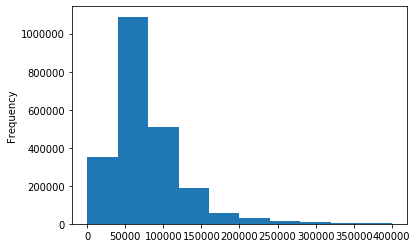

In [12]:
cln_input['annual_inc'][cln_input['annual_inc'] < cln_input['annual_inc'].quantile(0.997)].plot(kind='hist')

In [13]:
#### Fixes:
# By Assumption 6, income == 0 is not possible. Thus, set them to NULL.
cln_input.loc[(cln_input['annual_inc'] <= 0),'annual_inc'] = np.nan

# Since DTI = Monthly Debt / Monthly Income, with NULL Income, set DTI to NULL
cln_input.loc[(~cln_input['dti'].isna())&(cln_input['annual_inc'].isna()),'dti'] = np.nan

# By definition, DTI is a positive number. Set all negative DTIs to NULL
cln_input.loc[(cln_input['dti'] < 0),'dti'] = np.nan

In [14]:
data_count = cln_input.shape[0]
print('Num Loans:',data_count,'\n\nPercent missing...')
display((cln_input.drop(pt1_drop_cols,axis=1).isna()*1.0).sum(axis=0)*1.0/data_count)
print('Percent with value 0...\n')
display(((cln_input.drop(pt1_drop_cols,axis=1) == 0)*1.0).sum(axis=0)*1.0/data_count)

Num Loans: 2260668 

Percent missing...


loan_amnt        0.000000
funded_amnt      0.000000
term             0.000000
int_rate         0.000000
grade            0.000000
annual_inc       0.000739
loan_status      0.000000
dti              0.000763
revol_bal        0.000000
total_pymnt      0.000000
issue_d_year     0.000000
issue_d_month    0.000000
issue_d_num      0.000000
lateness         0.000000
dtype: float64

Percent with value 0...



loan_amnt        0.000000
funded_amnt      0.000000
term             0.000000
int_rate         0.000000
grade            0.000000
annual_inc       0.000000
loan_status      0.000000
dti              0.000763
revol_bal        0.005557
total_pymnt      0.000446
issue_d_year     0.000000
issue_d_month    0.000000
issue_d_num      0.000000
lateness         0.406824
dtype: float64

In [15]:
#### Fixes:
# NULL values make up an insignifcat portion of values and can therefore be safely discarded.
cln_input = cln_input.dropna()

In [16]:
data_count = cln_input.shape[0]
print('Num Loans:',data_count,'\n\nPercent missing...')
display((cln_input.drop(pt1_drop_cols,axis=1).isna()*1.0).sum(axis=0)*1.0/data_count)
print('Percent with value 0...\n')
display(((cln_input.drop(pt1_drop_cols,axis=1) == 0)*1.0).sum(axis=0)*1.0/data_count)

Num Loans: 2258943 

Percent missing...


loan_amnt        0.0
funded_amnt      0.0
term             0.0
int_rate         0.0
grade            0.0
annual_inc       0.0
loan_status      0.0
dti              0.0
revol_bal        0.0
total_pymnt      0.0
issue_d_year     0.0
issue_d_month    0.0
issue_d_num      0.0
lateness         0.0
dtype: float64

Percent with value 0...



loan_amnt        0.000000
funded_amnt      0.000000
term             0.000000
int_rate         0.000000
grade            0.000000
annual_inc       0.000000
loan_status      0.000000
dti              0.000763
revol_bal        0.005543
total_pymnt      0.000446
issue_d_year     0.000000
issue_d_month    0.000000
issue_d_num      0.000000
lateness         0.406531
dtype: float64

In [17]:
# for col_a in cln_input.columns:
#     for col_b in cln_input.columns:
#         if col_a == col_b:
#             continue
#         cln_input.plot(x=col_a,y=col_b,kind='hexbin')

In [18]:
cln_input['perc_pymnt'] = cln_input['total_pymnt']/cln_input['funded_amnt']

                index        0
0           loan_amnt    int64
1         funded_amnt    int64
2                term   object
3            int_rate  float64
4               grade   object
5          annual_inc  float64
6             issue_d   object
7         loan_status   object
8                 dti  float64
9           revol_bal    int64
10        total_pymnt  float64
11          grade_num    int64
12       issue_d_year   object
13      issue_d_month   object
14  issue_d_month_num    int64
15        issue_d_num    int64
16     credit_pol_flg  float64
17    loan_status_rev   object
18           lateness  float64
19         perc_pymnt  float64


/anaconda2/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


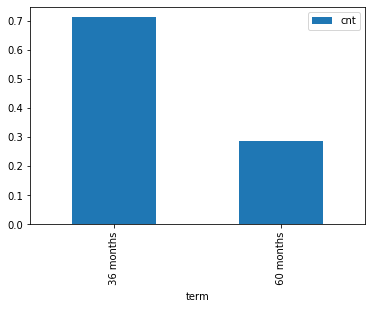

<Figure size 432x288 with 0 Axes>

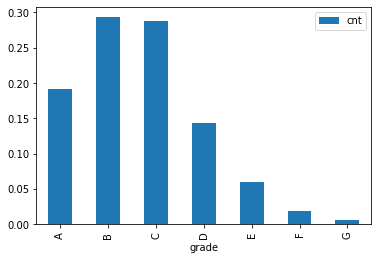

<Figure size 432x288 with 0 Axes>

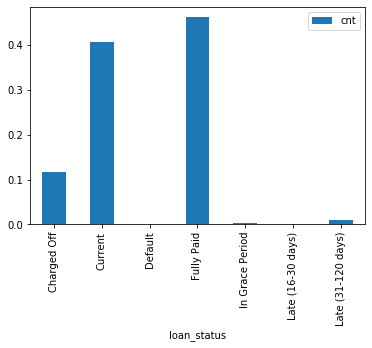

<Figure size 432x288 with 0 Axes>

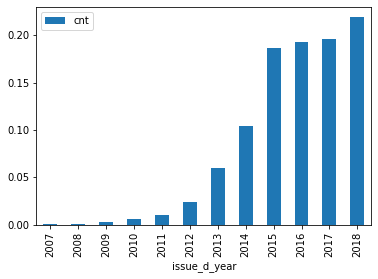

<Figure size 432x288 with 0 Axes>

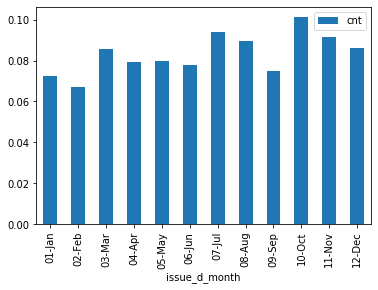

<Figure size 432x288 with 0 Axes>

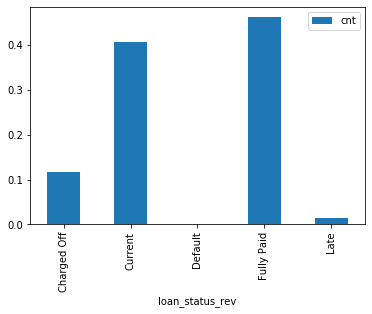

<Figure size 432x288 with 0 Axes>

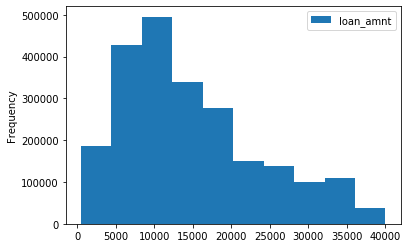

<Figure size 432x288 with 0 Axes>

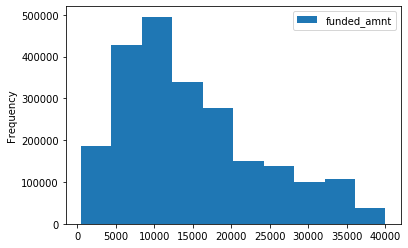

<Figure size 432x288 with 0 Axes>

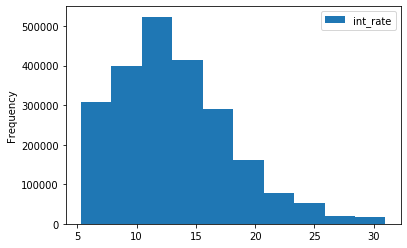

<Figure size 432x288 with 0 Axes>

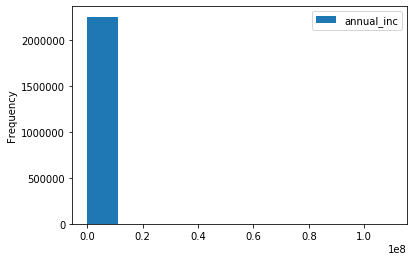

<Figure size 432x288 with 0 Axes>

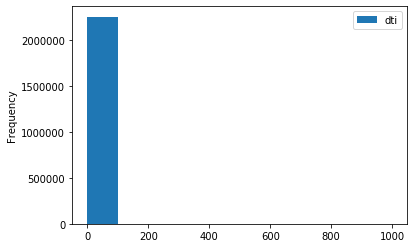

<Figure size 432x288 with 0 Axes>

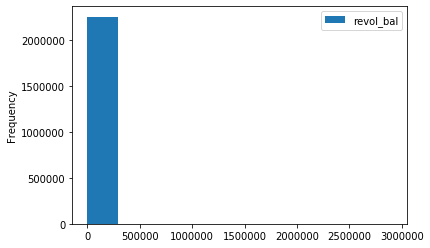

<Figure size 432x288 with 0 Axes>

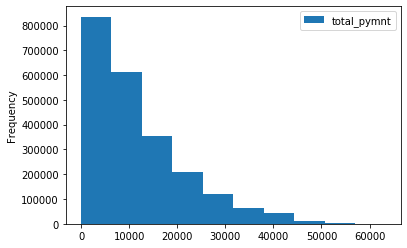

<Figure size 432x288 with 0 Axes>

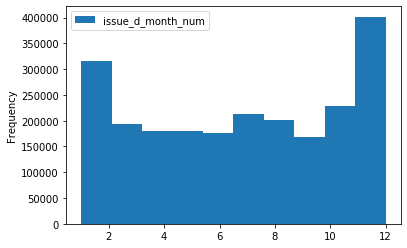

<Figure size 432x288 with 0 Axes>

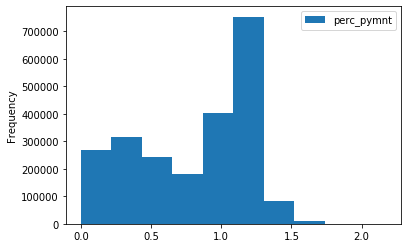

<Figure size 432x288 with 0 Axes>

In [19]:
# cln_input['annual_inc'][cln_input['annual_inc'] < cln_input['annual_inc'].quantile(0.997)].plot(kind='hist')
data_count = cln_input.shape[0]

ignore_cols = ['issue_d_num','issue_d','grade_num','lateness','credit_pol_flg']

print(pd.DataFrame(cln_input.dtypes).reset_index(drop=False))
col_list = pd.DataFrame(cln_input.drop(ignore_cols,axis=1).dtypes).reset_index(drop=False).copy()

obj_cols = col_list[col_list[0] == 'object']
num_cols = col_list[col_list[0] != 'object']

cln_input['cnt'] = 0

for obj_col in obj_cols['index'].to_list():
    (cln_input[[obj_col,'cnt']].groupby(obj_col).count()*1.0/data_count).plot(kind='bar')
    plt.figure()

for num_col in num_cols['index'].to_list():
    cln_input[[num_col]].plot(kind='hist')
    plt.figure()

cln_input = cln_input.drop('cnt',axis=1)

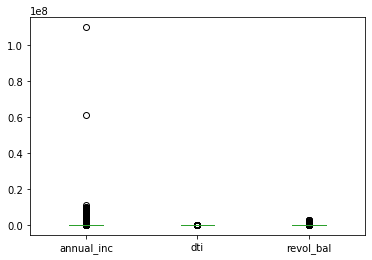

In [20]:
cln_input[['annual_inc','dti','revol_bal']].plot(kind='box')

In [21]:
# Exclude outlier income, dti, and revol_bal over the 99th percentile
cln_input = cln_input[cln_input['annual_inc'] < cln_input['annual_inc'].quantile(0.99)]
cln_input = cln_input[cln_input['dti'] < cln_input['dti'].quantile(0.99)]
cln_input = cln_input[cln_input['revol_bal'] < cln_input['revol_bal'].quantile(0.99)]

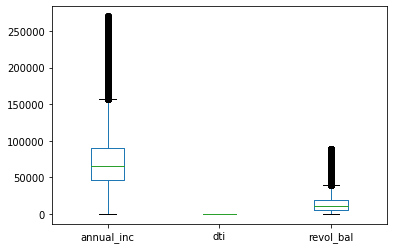

In [22]:
cln_input[['annual_inc','dti','revol_bal']].plot(kind='box')

                index        0
0           loan_amnt    int64
1         funded_amnt    int64
2                term   object
3            int_rate  float64
4               grade   object
5          annual_inc  float64
6             issue_d   object
7         loan_status   object
8                 dti  float64
9           revol_bal    int64
10        total_pymnt  float64
11          grade_num    int64
12       issue_d_year   object
13      issue_d_month   object
14  issue_d_month_num    int64
15        issue_d_num    int64
16     credit_pol_flg  float64
17    loan_status_rev   object
18           lateness  float64
19         perc_pymnt  float64


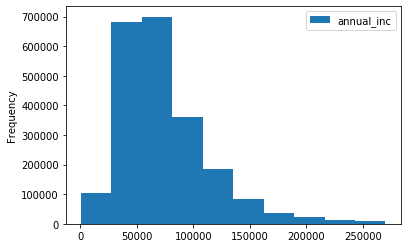

<Figure size 432x288 with 0 Axes>

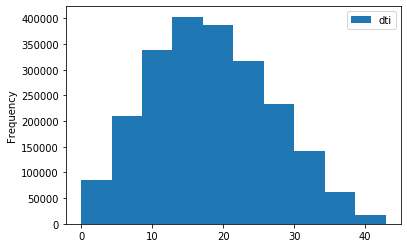

<Figure size 432x288 with 0 Axes>

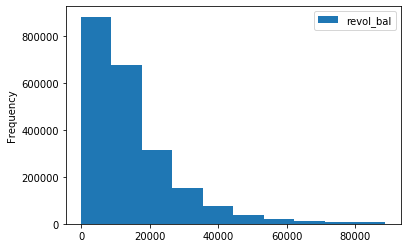

<Figure size 432x288 with 0 Axes>

In [23]:
# cln_input['annual_inc'][cln_input['annual_inc'] < cln_input['annual_inc'].quantile(0.997)].plot(kind='hist')
data_count = cln_input.shape[0]

keep_cols = ['annual_inc','dti','revol_bal']

print(pd.DataFrame(cln_input.dtypes).reset_index(drop=False))
col_list = pd.DataFrame(cln_input[keep_cols].dtypes).reset_index(drop=False).copy()

obj_cols = col_list[col_list[0] == 'object']
num_cols = col_list[col_list[0] != 'object']

cln_input['cnt'] = 0

for obj_col in obj_cols['index'].to_list():
    (cln_input[[obj_col,'cnt']].groupby(obj_col).count()*1.0/data_count).plot(kind='bar')
    plt.figure()

for num_col in num_cols['index'].to_list():
    cln_input[[num_col]].plot(kind='hist')
    plt.figure()

cln_input = cln_input.drop('cnt',axis=1)

In [24]:
# Based on Assumption 5, DTI should not be larger than 30%. Thus, any DTI ≥ 1 is likely written in percentages
# and should be scaled down by 100.
cln_input.loc[(cln_input['dti'] >= 1),'dti'] /= 100.0

# Continuing with Assumption 5, DTI should not be larger than 30%. However, to add room for the possibility
# of minor policy violations any DTI > 0.4 is excluded from the dataset...
cln_input = cln_input[cln_input['dti'] <= 0.4]

<Figure size 432x288 with 0 Axes>

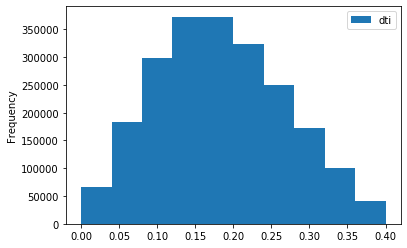

<Figure size 432x288 with 0 Axes>

In [25]:
cln_input[['dti']].plot(kind='hist')
plt.figure()

In [26]:
with pd.option_context('display.float_format', lambda x: '%.2f' % x):
    display(cln_input.drop(pt1_drop_cols,axis=1).describe())

,loan_amnt,funded_amnt,int_rate,annual_inc,dti,revol_bal,total_pymnt,issue_d_num,lateness,perc_pymnt
count,2179759.00,2179759.00,2179759.00,2179759.00,2179759.00,2179759.00,2179759.00,2179759.00,2179759.00,2179759.00
mean,14786.23,14781.06,13.10,73940.41,0.18,14810.26,11718.10,201590.08,0.16,0.81
std,9009.90,9007.99,4.81,39408.32,0.08,13012.17,9765.33,179.13,1.87,0.41
min,500.00,500.00,5.31,600.00,0.00,0.00,0.00,200706.00,-1.00,0.00
25%,8000.00,8000.00,9.49,46000.00,0.12,5897.00,4266.31,201504.00,-1.00,0.43
50%,12400.00,12375.00,12.62,65000.00,0.18,11120.00,9021.79,201606.00,0.00,1.01
75%,20000.00,20000.00,15.99,90454.40,0.24,19585.00,16564.19,201710.00,0.00,1.14
max,40000.00,40000.00,30.99,269950.00,0.40,88811.00,63296.88,201812.00,5.00,2.17


In [27]:
###################################
#### PART 2: Business Analysis ####
###################################

# Assumptions:
# 1. (See Above) This 2007-2018 data represents "present" data as of 11:59 PM on December 31, 2018.
#    Therefore, any loans originating after Dec. 2015 have less than 36 months of data
#    and should be excluded in Pt. 2 & Pt. 3.
# 2. Considering only 36 month loans indicates we are not considering a 36 month investment in a 60 month loan.
#    i.e. We hold until maturity.
#
#

In [28]:
# display(loans36.groupby(['lateness']).count())

#### Note: Lateness == -1 when the loan is Fully Paid
cln_input['paid_flg'] = (cln_input['lateness'] < 0)*1.0


In [29]:
#### Load only 36 month term loans.
loans36 = cln_input[(cln_input['term'].str.contains('36'))].copy()

### Exclude loans with less than 36 months of data. (Assumption 1)
loans36 = loans36[(loans36['issue_d_num'] <= 201512)].reset_index(drop=True)

In [30]:
##########################################################################
#### Pt.2 — Question 1: What percentage of loans has been fully paid? ####
##########################################################################

print('% of loans fully paid:',loans36['paid_flg'].sum()*1.0/loans36['paid_flg'].count())

#### Answer: 85.9%

% of loans fully paid: 0.8592428728853503


In [31]:
###############################################################################
#### Pt.2 — Question 2: When bucketed by year of origination and grade,    ####
####        which cohort has the highest rate of defaults? Here you may    ####
####        assume that any loan which was not fully paid had “defaulted”? ####
###############################################################################

loans36_tmp = loans36[['issue_d_year','grade','paid_flg']].copy()

loans36_tmp['default_flg'] = 1-loans36_tmp['paid_flg']
loans36_tmp = loans36_tmp.drop('paid_flg',axis=1)

loans36_tmp_gb = loans36_tmp.groupby(['issue_d_year','grade']).agg(['sum','count'])['default_flg']
loans36_tmp_gb['def_perc'] = loans36_tmp_gb['sum']*1.0/loans36_tmp_gb['count']

display(loans36_tmp_gb.sort_values('def_perc',ascending=False).head(50))

#### Answer: The year/grade cohort — Year:2015 / Grade:G — has the highest rate of default (of 47.0%)

sum  count  def_perc
issue_d_year grade                          
2015         G        116.0    247  0.469636
2007         F         22.0     48  0.458333
             G         14.0     32  0.437500
2015         F        576.0   1354  0.425406
2014         G         64.0    175  0.365714
2008         F         36.0    106  0.339623
2011         G          3.0      9  0.333333
2010         G         11.0     33  0.333333
2015         E       3085.0   9322  0.330938
2007         E         30.0     93  0.322581
             D         30.0     94  0.319149
2008         G         24.0     78  0.307692
2009         G         14.0     47  0.297872
2014         F        579.0   1953  0.296467
2010         F         25.0     86  0.290698
2013         G          4.0     14  0.285714
2008         E         75.0    277  0.270758
2014         E       1888.0   6979  0.270526
2015         D       8530.0  32254  0.264463
2013         F        155.0    591  0.262267
2009         F         25.0     97  0.257732
2008         D        104.0    404  0.257426
2011         F         13.0     53  0.245283
2007         C         32.0    136  0.235294
2013         E        746.0   3175  0.234961
2014         D       4504.0  20220  0.222750
2012         E        171.0    782  0.218670
2009         E         64.0    294  0.217687
2012         D       1067.0   5019  0.212592
2011         E         55.0    264  0.208333
2008         C        114.0    553  0.206148
2013         D       2929.0  14346  0.204168
2015         C      14941.0  76327  0.195750
2012         F         19.0    100  0.190000
2010         D        229.0   1210  0.189256
             E         58.0    314  0.184713
2011         D        226.0   1228  0.184039
2012         G          4.0     22  0.181818
2009         D        140.0    781  0.179257
2012         C       1735.0   9829  0.176518
2014         C       7493.0  43417  0.172582
2008         B         95.0    558  0.170251
2011         C        340.0   2151  0.158066
2007         B         14.0     89  0.157303
2013         C       3736.0  24387  0.153196
2009         C        199.0   1300  0.153077
2010         C        267.0   2003  0.133300
2012         B       2091.0  16643  0.125638
2015         B      10832.0  89880  0.120516
2009         B        166.0   1378  0.120464

In [32]:
####################################################################################
#### Pt.2 — Question 3: When bucketed by year of origination and grade, what    ####
####                    annualized rate of return have these loans generated    ####
####                    on average?                                             ####
####                                                                            ####
#### Using: Annualized rate of return = (total_pymnt / funded_amnt) ^ (1/3) - 1 ####
####                                                                            ####
####################################################################################

#### Unbucketed:
loans36_tmp_ub = loans36[['total_pymnt','funded_amnt']].copy().sum()
print('Unbucketed ARR:',(loans36_tmp_ub['total_pymnt']/loans36_tmp_ub['funded_amnt'])**(1/3) - 1)
#### Unbucketed Answer: ARR = 2.66%


#### Year/Grade Bucket:
loans36_tmp = loans36[['issue_d_year','grade','total_pymnt','funded_amnt']].copy()

loans36_tmp_gb = loans36_tmp.groupby(['issue_d_year','grade']).sum()
loans36_tmp_gb['arr'] = (loans36_tmp_gb['total_pymnt']/loans36_tmp_gb['funded_amnt'])**(1/3) - 1

loans36_2015_G = loans36_tmp_gb.loc[('2015','G')]

print('2015/G ARR:',loans36_2015_G['arr'])
#### Year/Grade — 2015/G — Bucket Answer: ARR = -1.63%


#### All Buckets:
display(loans36_tmp_gb)

Unbucketed ARR: 0.026647115898971174
2015/G ARR: -0.01629791078984033


total_pymnt  funded_amnt       arr
issue_d_year grade                                     
2007         A      3.717366e+05       340000  0.030193
             B      7.105348e+05       685850  0.011856
             C      1.108930e+06      1080750  0.008617
             D      6.858957e+05       688250 -0.001142
             E      6.697176e+05       688125 -0.008997
...                          ...          ...       ...
2015         C      9.556816e+08    897570475  0.021131
             D      4.100598e+08    391350075  0.015689
             E      1.206900e+08    118441775  0.006288
             F      1.377484e+07     14023850 -0.005954
             G      2.271016e+06      2385775 -0.016298

[63 rows x 3 columns]

In [33]:
##########################
#### PART 3: Modeling ####
##########################

# Assumptions:
# 1. Ability to invest in each loan independently
# 2. Invest immediately following origination and hold 36 months (to maturity)
# 3. All loan fields known upon origination are made available.
#
# 4. Funded amount is *not* known upon origination.
# 5. Although revol_bal was assumed in Part 2 to be continuously updated, I'm assuming here that
#    the revolving balanace at the start of the loan was equal to its present value.


In [34]:
#### Build dataframe with input features, X, and output variable, y such that X only includes
#### information known prior to loan origination.

loans_36mod = loans36.copy()

loans_36mod['total_debt'] = loans_36mod['dti']*loans_36mod['annual_inc']
loans_36mod['loan_inc_ratio'] = loans_36mod['loan_amnt']*1.0/loans_36mod['annual_inc']


prior_cols = ['loan_amnt','int_rate','grade_num','annual_inc',
              'dti','revol_bal','issue_d_year','issue_d_month_num','issue_d_num',
              
              'total_debt', # New features starting in this section...
              'loan_inc_ratio'
             
             ]

eval_cols = ['total_pymnt']

loans36_log = loans_36mod[prior_cols+eval_cols+['paid_flg']].copy().rename({'paid_flg':'y'},axis=1)

In [35]:
### Using most recent data as test / cross validation data in order to avoid temporal bias in training data
### since origination date is being included as a feature.

a = loans36_log.groupby(['issue_d_num']).count()[['loan_amnt']]/loans36_log.count()[['loan_amnt']]
a

### Allocating 20% to cross validation, 20% to test. ~40% of data is included in 2015-03 thru 2015-12.
### Using this for CV / Test data...

,loan_amnt
issue_d_num,
200706,0.000036
200707,0.000099
200708,0.000110
200709,0.000077
200710,0.000166
...,...
201508,0.038390
201509,0.030052
201510,0.053182


In [36]:
#### Function for building training / cross validation / test data sets
def built_train_cv_test(loans36_log,prior_cols,eval_cols):
    
    train_data = loans36_log[loans36_log['issue_d_num'] < 201503]
    cv_test_data = loans36_log[loans36_log['issue_d_num'] >= 201503]

    X_train = train_data[prior_cols+eval_cols].copy().drop('issue_d_num',axis=1)
    y_train = train_data['y'].copy()

    X_cv_test = cv_test_data[prior_cols+eval_cols].copy().drop('issue_d_num',axis=1)
    y_cv_test = cv_test_data['y'].copy()

    X_cv, X_test, y_cv, y_test = train_test_split(X_cv_test,y_cv_test,test_size=0.5)
    
    eval_train = X_train[eval_cols]
    eval_cv = X_cv[eval_cols]
    eval_test = X_test[eval_cols]
    
    X_train = X_train.drop(eval_cols,axis=1)
    X_cv = X_cv.drop(eval_cols,axis=1)
    X_test = X_test.drop(eval_cols,axis=1)

    return X_train.reset_index(drop=True),X_cv.reset_index(drop=True),X_test.reset_index(drop=True), \
           y_train.reset_index(drop=True),y_cv.reset_index(drop=True),y_test.reset_index(drop=True), \
           eval_train.reset_index(drop=True), eval_cv.reset_index(drop=True), eval_test.reset_index(drop=True)

In [37]:
#### Function for evaluating model's Annualized Rate of Return
def calculate_arr(X,y,eval_,logistic_reg,thresh=0.9):
    full_view = (X.join(y).join(pd.DataFrame(logreg.predict_proba(X)[:,1],columns=['prob'])).join(eval_)).copy()
    full_view = full_view[full_view['prob'] >= thresh]
    
    full_view['individ_arr'] = (full_view['total_pymnt']/full_view['loan_amnt'])**(1/3) - 1
    
    fv_sum = full_view.sum()
    
    arr_out = (fv_sum['total_pymnt']/fv_sum['loan_amnt'])**(1/3) - 1
    
    print('>> ARR of Logistic Regression with Threshold:',thresh,'=',np.round(arr_out,decimals=4))
    return arr_out

In [38]:
### Examining model results without using one-hot function

X_train,X_cv,X_test, \
y_train,y_cv,y_test, \
eval_train,eval_cv,eval_test= built_train_cv_test(loans36_log,prior_cols,eval_cols)

logreg = LogisticRegression(solver='lbfgs').fit(X_train,y_train)
print(logreg.score(X_train,y_train))
print(logreg.score(X_cv,y_cv))
print(logreg.predict(X_test))
print()

a = pd.DataFrame(logreg.predict_proba(X_cv)[:,1])
thresh = 0.9

print(a[a[0] <= thresh].shape)
print(a[a[0] > thresh].shape)
print()
b = pd.DataFrame(y_cv)
print(b[b['y'] <= thresh].shape)
print(b[b['y'] > thresh].shape)

0.8661282929328336
0.8486867532642122
[1. 1. 1. ... 1. 1. 1.]

(64210, 1)
(54808, 1)

(18022, 1)
(100996, 1)


In [39]:
#### VERY much overestimating likelihood of repayment
# Trying now with one_hot for grade_num
loans36_log_oh = loans36_log.copy()
loans36_log_oh = pd.get_dummies(loans36_log_oh,columns=['grade_num'])

prior_cols_oh = [_ for _ in loans36_log_oh.columns if _ != 'y' and _ not in eval_cols]

X_train,X_cv,X_test, \
y_train,y_cv,y_test, \
eval_train,eval_cv,eval_test = built_train_cv_test(loans36_log_oh,prior_cols_oh,eval_cols)

logreg = LogisticRegression(solver='lbfgs').fit(X_train,y_train)
print(logreg.score(X_train,y_train))
print(logreg.score(X_cv,y_cv))
print(logreg.score(X_test,y_test))
print(logreg.predict_proba(X_test))
print()

a = pd.DataFrame(logreg.predict_proba(X_cv)[:,1])

thresh = 0.9

print(a[a[0] <= thresh].shape)
print(a[a[0] > thresh].shape)
print()
b = pd.DataFrame(y_cv)
print(b[b['y'] <= thresh].shape)
print(b[b['y'] > thresh].shape)

0.86612290020762
0.8490396410626964
0.8480494710928507
[[0.07391134 0.92608866]
 [0.1446409  0.8553591 ]
 [0.12374539 0.87625461]
 ...
 [0.17809473 0.82190527]
 [0.08495652 0.91504348]
 [0.12334572 0.87665428]]

(63658, 1)
(55360, 1)

(17964, 1)
(101054, 1)


In [ ]:
tmp = loans36_log[loans36_log['issue_d_num'] >= 201503].sum()
print('Blindly investing in 03-2015 - 12-2015 gives ARR of:',np.round((tmp['total_pymnt']/tmp['loan_amnt'])**(1/3) - 1,decimals=4))
print()

best_arr = 0.0
best_thresh = 0.0

for thresh in [0.5,0.6,0.7,0.8,0.9,0.95,0.96,0.97,0.98]:
    print('Threshold:',thresh)
    for v,X,y,ev in [('train',X_train,y_train,eval_train),
                   ('cv',X_cv,y_cv,eval_cv)]:
        print('>> Dataset:',v)
        arr_tmp = calculate_arr(X,y,ev,logreg,thresh=thresh)
        if v == 'cv' and arr_tmp >= best_arr:
            best_thresh = thresh
        print()

print('Best thresh =',best_thresh,'with ARR...')
calculate_arr(X_test,y_test,eval_test,logreg,thresh=best_thresh)

Blindly investing in 03-2015 - 12-2015 gives ARR of: 0.0207

Threshold: 0.5
>> Dataset: train
>> ARR of Logistic Regression with Threshold: 0.5 = 0.0303

>> Dataset: cv
>> ARR of Logistic Regression with Threshold: 0.5 = 0.0207

Threshold: 0.6
>> Dataset: train
>> ARR of Logistic Regression with Threshold: 0.6 = 0.0303

>> Dataset: cv
>> ARR of Logistic Regression with Threshold: 0.6 = 0.0208

Threshold: 0.7
>> Dataset: train
>> ARR of Logistic Regression with Threshold: 0.7 = 0.0303

>> Dataset: cv
>> ARR of Logistic Regression with Threshold: 0.7 = 0.021

Threshold: 0.8
>> Dataset: train


In [ ]:
#######################################################
#### What percentage of loans has been fully paid? ####
#######################################################
print('% of loans fully paid:',y_test[(X_test['issue_d_month_num'] >= 3)&(X_test['issue_d_year'] >= '2015')].sum()*1.0/y_test[(X_test['issue_d_month_num'] >= 3)&(X_test['issue_d_year'] >= '2015')].count())

#### Answer: 85.9%